In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel

import numpy as np
import pandas as pd

SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = '../../'

In [4]:
sm = stepmodel.read_zip(training_folder + 'model/{scen}/aon_pathfinder.zip'.format(scen=scenario))

zones: 100%|███████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 19.74it/s]


# generation
- Production = Population
- Attraction = Jobs

In [5]:
sm.zones['emission'] =  sm.zones['pop'].astype(int) / 10 # peak hour generation
sm.zones['attraction'] =  sm.zones['emp'].astype(int) / 10
sm.zones['pop'].sum()

2158238.2271273527

# car owners
car owners distribution is based on car times

In [6]:
motor_rate = 0.3
car = sm.copy()
car.zones['emission'] *= motor_rate

In [8]:
imp_matrix = car.car_los[
    ['origin', 'destination', 'time']
].set_index(['origin','destination']).unstack() 
imp_matrix = imp_matrix.replace(0, 120)

car.step_distribution(deterrence_matrix=imp_matrix)

# PT captives
car owners distribution is based on car times

In [9]:
pt = sm.copy()
pt.zones['emission'] *= (1-motor_rate)

In [10]:
# Ici on prend comme fonction de coût le temps TC. Notez le .unstack() 
imp_matrix = pt.pt_los[
    ['origin', 'destination', 'gtime']
].set_index(['origin','destination']).unstack() 
imp_matrix = imp_matrix.replace(0, 120)

In [11]:
imp_matrix

gtime                                                      \
destination       zone_0       zone_1      zone_10     zone_100     zone_101   
origin                                                                         
zone_0        120.000000   663.093344  1137.661537  1704.977130  1906.671059   
zone_1        663.093344   120.000000  1317.509165  1540.918037  1806.180615   
zone_10      1137.661537  1363.883134   120.000000  1879.392951  2141.086880   
zone_100     1732.143131  1600.918037  1966.558952   120.000000  1319.238609   
zone_101     1906.671059  1806.180615  2141.086880  1319.238609   120.000000   
...                  ...          ...          ...          ...          ...   
zone_95      1548.187680  1447.697235  1782.603500   990.755229   985.283157   
zone_96      1831.285436  1667.226344  2095.701257   913.852986  1180.245077   
zone_97      1686.358433  1585.867989  1920.774254   811.925280  1123.017444   
zone_98      1890.954080  1790.463636  2125.369900   943.521630  1100.589351   
zone_99      1780.615340  1680.124896  2015.031160  1223.182890   907.941916   

                                                                              \
destination     zone_102     zone_103     zone_104     zone_105     zone_106   
origin                                                                         
zone_0       1604.876340  1962.561774  1834.972437  1670.250318  1548.403429   
zone_1       1504.385896  1798.502681  1670.913344  1506.191225  1447.912985   
zone_10      1989.292161  2136.977595  2009.388258  1844.666138  1932.819250   
zone_100     1616.044325  1201.379862  1016.397697   890.180293  1773.804977   
zone_101     2032.233923  1461.521415  1545.104139  1625.850511  2067.884147   
...                  ...          ...          ...          ...          ...   
zone_95      1669.254874  1407.424410  1274.756596  1228.862416  1827.015527   
zone_96      1457.020362   904.271628   837.854353  1040.464888  1510.634361   
zone_97      1740.460128  1328.629664  1195.961850  1118.537182  1898.220781   
zone_98      1706.296582  1153.547849  1087.130573  1250.133531  1759.910581   
zone_99      1901.682534  1639.852071  1507.184256  1461.290076  2059.443187   

             ...                                                      \
destination  ...      zone_90      zone_91      zone_92      zone_93   
origin       ...                                                       
zone_0       ...  1758.858140  1513.401300  1874.410816  1578.200113   
zone_1       ...  1732.809590  1499.342208  1791.133923  1571.717876   
zone_10      ...  1933.273960  1687.817121  2048.826637  1782.615934   
zone_100     ...  1711.425689  1406.587301  1724.191917  1110.767663   
zone_101     ...  1975.953617  1671.115229  1713.188138  1009.763884   
...          ...          ...          ...          ...          ...   
zone_95      ...  1527.470238  1222.631850  1390.236465   656.812212   
zone_96      ...  1840.567994  1535.729606  1853.334222  1239.909968   
zone_97      ...  1665.640991  1360.802603  1678.407219  1064.982965   
zone_98      ...  1870.236638  1565.398250  1883.002865  1269.578612   
zone_99      ...  1702.984514  1455.059510  1408.426931   679.239872   

                                                                              \
destination      zone_94      zone_95      zone_96      zone_97      zone_98   
origin                                                                         
zone_0       1596.915043  1608.187680  1839.470459  1715.921966  1890.954080   
zone_1       1496.424599  1567.697235  1675.411366  1615.431522  1790.463636   
zone_10      1831.330864  1902.603500  2013.886279  1950.337787  2125.369900   
zone_100      979.482593  1050.755229   973.852986   811.925280  1003.521630   
zone_101     1244.010521  1023.897156  1120.245077  1123.017444  1100.589351   
...                  ...          ...          ...          ...          ...   
zone_95       749.555728   120.000000  1179.8975

In [13]:
pt.step_distribution(deterrence_matrix=imp_matrix)

In [14]:
pt.volumes

,origin,destination,volume
0,zone_0,zone_0,0.009193
1,zone_0,zone_1,0.342807
2,zone_0,zone_2,0.296726
3,zone_0,zone_3,0.422609
4,zone_0,zone_4,0.393832
...,...,...,...
12095,zone_109,zone_105,1.557870
12096,zone_109,zone_106,6.656906
12097,zone_109,zone_107,4.397028
12098,zone_109,zone_108,4.031129


# merge matrices

In [15]:
sm.volumes = pd.merge(
    car.volumes,
    pt.volumes,
    on=['origin', 'destination'],
    suffixes=[ '_car_owner', '_pt_captive']
).rename(columns={'volume_car_owner': 'car_owner', 'volume_pt_captive': 'pt_captive'})

# to_zip

In [16]:
sm.to_zip(
    training_folder + 'model/{scen}/distribution.zip'.format(scen=scenario), 
    only_attributes=['volumes', 'epsg', 'coordinates_unit']
)

jsons: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 40.75it/s]


# monitoring

Text(0.5, 1.0, 'PT captives distribution')

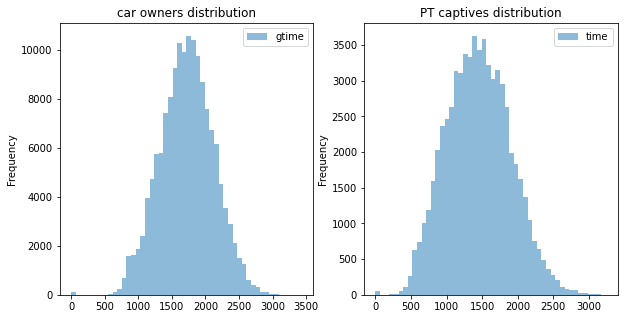

In [17]:
od = pd.merge(sm.volumes, sm.pt_los, on=['origin', 'destination'])
od = pd.merge(od, sm.car_los, on=['origin', 'destination'])
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=[10, 5])
plot = od[['gtime']].plot(kind='hist', weights=od['pt_captive'], bins=50, alpha=0.5, ax=axes[0])
plot.set_title('car owners distribution')
plot = od[['time']].plot(kind='hist', weights=od['car_owner'], bins=50, alpha=0.5, ax=axes[1])
plot.set_title('PT captives distribution')

# END